**NOTE**

Need to manually add Kraken's delisted stocks eventually to data because of survivorship bias

In [44]:
import util
from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timezone
from numba import njit
import pickle
import os
import sqlite3
from dotenv import load_dotenv
import yfinance as yf
import strategies
import seaborn as sns
load_dotenv()
util = reload(util)

In [57]:

kraken_coin_data = util.get_exchange_coins('kraken')
kraken_coin_ids = [coin['coin_id'] for coin in kraken_coin_data]
kraken_symbols = [coin['base'].lower() for coin in kraken_coin_data]
tradable_kraken_coins = util.get_tradable_kraken_coins()
all_data = util.get_all_ochl()

kraken_data = all_data[all_data['coin_id'].isin(kraken_coin_ids)]
coins_to_exclude = [
        'tether', 
        'usd-coin', 
        'true-usd', 
        'wrapped-bitcoin',
        'dai',
        'terra-luna',
        'ftx-token',
        'bora',
        'theta-fuel',
        'gifto',
        'amber',
        'cocos-bcx',
        'beldex',
        'usdc',
    ]
exclude_coins_symbol = [coin['base'].lower() for coin in kraken_coin_data if coin['coin_id'] in coins_to_exclude]
all_close_prices = util.get_col_pivot_from_all_ochl(type ='close',volume_threshold= 100000)
all_high_prices = util.get_col_pivot_from_all_ochl(type ='high', volume_threshold=100000)
all_low_prices = util.get_col_pivot_from_all_ochl(type ='low', volume_threshold=100000)
all_vol = util.get_col_pivot_from_all_ochl(type='volume' ,volume_threshold=100000)
kraken_columns = list(set(all_close_prices.columns).intersection(set(kraken_symbols))-set(exclude_coins_symbol))
all_kraken_close_prices = np.log(all_close_prices[kraken_columns])
all_kraken_high_prices = np.log(all_high_prices[kraken_columns])
all_kraken_low_prices = np.log(all_low_prices[kraken_columns])
all_kraken_vol = all_vol[kraken_columns]
kraken_ret = (util.transform_returns(kraken_data, volume_threshold=100000))


In [204]:
reload(util)
modified_ret = util.monotonic_tail_cleansing(kraken_ret[kraken_columns])
num_non_nan = modified_ret.count()
filter_columns = (num_non_nan[num_non_nan > 10000]).index
modified_ret = modified_ret[filter_columns]
kraken_trading_activity = np.power(modified_ret.rolling(24, min_periods=1).std()*all_kraken_vol, 2/3)
log_trading_activity = np.log1p(kraken_trading_activity)
start_date_in_sample = '2019-01-01'
end_date_in_sample = '2023-12-31'
start_date_out_of_sample = '2024-01-01'
def get_in_sample(df):
    return df.loc[start_date_in_sample:end_date_in_sample][filter_columns]
def get_out_of_sample(df):
    return df.loc[start_date_out_of_sample:][filter_columns]
in_sample_ret = get_in_sample(modified_ret)
in_sample_close_prices = get_in_sample(all_kraken_close_prices)
in_sample_high_prices = get_in_sample(all_kraken_high_prices)
in_sample_low_prices = get_in_sample(all_kraken_close_prices)
out_of_sample_ret = get_out_of_sample(modified_ret)
out_of_sample_close_prices = get_out_of_sample(all_kraken_close_prices)
out_of_sample_high_prices = get_out_of_sample(all_kraken_high_prices)
out_of_sample_low_prices = get_out_of_sample(all_kraken_low_prices)

Probably only include coins that have more than 1000 entries. Also min_period should probably be set to a value > 1 for my trading rules due to spurious return/other data.

In [205]:
reload(util)
entropy_ret = in_sample_ret.apply(util.entropy, axis=0)
entropy_ret.sort_values(ascending=True)

symbol
xcn       0.513692
shib      0.531408
pyusd     0.584487
doge      0.600195
flr       0.607084
            ...   
tao       0.788483
spx       0.826209
beam      0.836721
tia       0.849910
popcat    0.955421
Length: 67, dtype: float64

<Axes: >

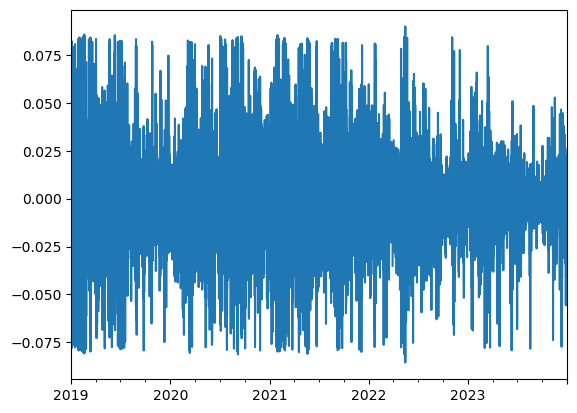

In [206]:
in_sample_ret['ftm'].plot()